### Download dataset from kaggle

In [252]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("deeptrial/miniimagenet")

print("Path to dataset files:", path)

100%|██████████| 477M/477M [01:12<00:00, 6.86MB/s] 

Extracting files...


Path to dataset files: C:\Users\ShivajiWankhede\.cache\kagglehub\datasets\deeptrial\miniimagenet\versions\2


### Dataset before detection

In [186]:
import os

root_folder= 'D:/yogi/shoppin/ImageNet-Mini/images'
img_paths= []
labels= []

for dir, folder, files in os.walk(root_folder):

  for file in files:
    img_path= os.path.join(dir, file)
    img_paths.append(img_path)
    labels.append(os.path.basename(dir))

In [190]:
from sklearn import preprocessing

label_encoder= preprocessing.LabelEncoder()
img_ids= label_encoder.fit_transform(labels)

### Dataset after augmentation

In [2]:
import os

root_folder= 'D:/yogi/shoppin/ImageNet-Mini/augmented_images_200'
img_paths= []
labels= []

for dir, folder, files in os.walk(root_folder):

  for file in files:
    img_path= os.path.join(dir, file)
    img_paths.append(img_path)
    labels.append(os.path.basename(dir))

In [3]:
from sklearn import preprocessing

label_encoder= preprocessing.LabelEncoder()
img_ids= label_encoder.fit_transform(labels)

### Dataset after Detection

In [1]:
import zipfile
import os

dataset= 'detected_objects'

# Unzip the dataset
with zipfile.ZipFile("C:/Users/ShivajiWankhede/Downloads/" + dataset + '.zip', 'r') as zip_ref:
    zip_ref.extractall(dataset)  # Extract to a folder named "dataset"

# List the extracted files
print(os.listdir(dataset))

['airplane', 'apple', 'backpack', 'banana', 'baseball bat', 'baseball glove', 'bear', 'bed', 'bench', 'bicycle', 'bird', 'boat', 'book', 'bottle', 'bowl', 'broccoli', 'bus', 'cake', 'car', 'carrot', 'cat', 'cell phone', 'chair', 'clock', 'couch', 'cow', 'cup', 'dining table', 'dog', 'donut', 'elephant', 'fire hydrant', 'fork', 'frisbee', 'giraffe', 'handbag', 'horse', 'hot dog', 'keyboard', 'kite', 'knife', 'laptop', 'microwave', 'motorcycle', 'mouse', 'orange', 'oven', 'parking meter', 'person', 'pizza', 'potted plant', 'refrigerator', 'remote', 'sandwich', 'scissors', 'sheep', 'sink', 'skateboard', 'skis', 'snowboard', 'spoon', 'sports ball', 'stop sign', 'suitcase', 'surfboard', 'teddy bear', 'tennis racket', 'tie', 'toaster', 'toilet', 'toothbrush', 'traffic light', 'train', 'truck', 'tv', 'umbrella', 'vase', 'wine glass', 'zebra']


In [2]:
input_folder= './detected_objects'

detected_img_paths= []
detected_img_labels= []
folders= set()

for dir, folder, files in os.walk(input_folder):

  for f in folder:
    folders.add(f)

  for file in files:
    label= os.path.basename(dir)
    path= os.path.join(dir, file)
    detected_img_paths.append(path)
    detected_img_labels.append(label)

In [3]:
from sklearn import preprocessing

label_encoder= preprocessing.LabelEncoder()
detected_img_ids= label_encoder.fit_transform(detected_img_labels)

### Dataloader

In [5]:
import os
import pandas as pd
from PIL import Image
from torchvision.io import read_image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, target_transform=None):
        self.image_paths = image_paths
        self.labels= labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [7]:
def transform_image():
  
  transform= transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomResizedCrop(224),
      transforms.ToTensor(),
      transforms.Lambda(lambda img: img.repeat(3, 1, 1) if img.shape[0] == 1 else img),
      transforms.Normalize(mean=0.5,  # Standard ImageNet normalization
      std=0.5)
  ])

  return transform

In [8]:
from math import floor
import random

def split_data(img_paths, img_ids):

    # Combine data and labels into a list of tuples
    combined = list(zip(img_paths, img_ids))

    random.seed(42)

    # Shuffle the combined list
    random.shuffle(combined)

    # Split the shuffled combined list into two lists
    split_index1 = floor(len(combined) * 0.8)
    split_index2 = floor(len(combined) * 0.9)

    train_combined  = combined[:split_index1]
    test_combined   = combined[split_index1:split_index2]
    enroll_combined = combined[split_index2:]

    # Unpack the combined tuples into separate paths and labels
    train_img_paths, train_img_ids   = zip(*train_combined)
    test_img_paths, test_img_ids     = zip(*test_combined)
    enroll_img_paths, enroll_img_ids = zip(*enroll_combined)

    return train_img_paths, train_img_ids, test_img_paths, test_img_ids, enroll_img_paths, enroll_img_ids


In [9]:
train_img_paths, train_img_ids, test_img_paths, test_img_ids, enroll_img_paths, enroll_img_ids= split_data(img_paths, img_ids)

In [10]:
training_data   = CustomImageDataset(train_img_paths, train_img_ids, transform_image())
val_data        = CustomImageDataset(test_img_paths, test_img_ids, transform_image())

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)

### Model Configuration

In [11]:
import torch
from torchvision.models import resnet50, resnet34, resnet18, vit_b_16
import torch.nn as nn
from torch.optim import SGD
from torch.nn import CrossEntropyLoss

In [12]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
model= resnet34(weights= True)

c:\Users\ShivajiWankhede\anaconda3\envs\llm\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
in_features= 512
classes= 200

model.fc= nn.Sequential(
    nn.Linear(in_features, classes))

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criteria= CrossEntropyLoss()

### Training & Testing

In [16]:
model.load_state_dict(torch.load('./checkpoints/model_200.pth'))

C:\Users\ShivajiWankhede\AppData\Local\Temp\ipykernel_26408\1210933264.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./checkpoints/mo

<All keys matched successfully>

In [17]:
model= model.to(device)

In [18]:
def Train(model, train_dataloader, epoch):
  model.train()
  loss_running= 0
  total= 0
  correct= 0

  for idx, (inputs, labels) in enumerate(train_dataloader):
    inputs= inputs.to(device)
    labels= labels.to(device)
    outputs= model(inputs).to(device)

    loss = criteria(outputs, labels)
    loss_running += loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, predicted = outputs.max(1)

    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

    # print(f'Epoch {epoch + 1}: Batch idx: {idx}/{len(train_dataloader)} train accuracy: {correct/total} | train loss: {loss}')

  print(f'Epoch {epoch + 1}: train accuracy: {correct/total} | train loss: {loss_running/len(train_dataloader)}')

In [19]:
def Test(model, test_dataloader, epoch=0):
    model.eval()
    total= 0
    correct= 0
    predictions= []
    true_labels= []

    for input, labels in test_dataloader:
        input= input.to(device)
        labels= labels.to(device)
        outputs= model(input).to(device)

        _, predicted = outputs.max(1)
        predictions.extend(predicted)
        true_labels.extend(labels)

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f'Epoch: {epoch + 1} | test accuracy: {correct/total}')

In [20]:
epochs= 2

for i in range(epochs):
    Train(model, train_dataloader, i)
    Test(model, val_dataloader, i)

Epoch 1: train accuracy: 0.9646935908059229 | train loss: 0.14787638187408447
Epoch: 1 | test accuracy: 0.9668587896253602
Epoch 2: train accuracy: 0.96602658788774 | train loss: 0.1417543739080429
Epoch: 2 | test accuracy: 0.9694524495677234


In [21]:
torch.save(model.state_dict(), './checkpoints/model_200.pth')

### Save the Trained model

In [25]:
def save_feature_extractor(model, saved_model_name= "checkpoints/feature_extractor.pth"):

    # Convert the model to a list, exclude the last layer, and create a new Sequential model
    model_without_last_layer = nn.Sequential(*list(model.children())[:-1])
    # Save the modified model
    torch.save(model_without_last_layer.state_dict(), saved_model_name)
    print("Model saved without the last layer.")

In [26]:
def save_model(model, saved_model_name= "model.pth"):

    # Save the modified model
    torch.save(model.state_dict(), saved_model_name)
    print("Model saved.")

In [27]:
save_model(model, 'checkpoints/model_without_detector.pth')
save_feature_extractor(model, 'checkpoints/feature_extractor_without_detector.pth')

Model saved.
Model saved without the last layer.


### Load the trained model

In [16]:
def load_model(path=None):
    model= resnet34(weights=True)
    model = nn.Sequential(*list(model.children())[:-1])
    model.load_state_dict(torch.load('checkpoints/feature_extractor_without_detector.pth'))

    return model

In [17]:
model= load_model()

### Enrollment

In [33]:
import json

# Convert tensors to lists for serialization
def tensor_to_list(obj):
    if isinstance(obj, torch.Tensor):
        return obj.tolist()  # Convert tensor to list
    raise TypeError(f"Object of type {obj.__class__.__name__} is not serializable")

def enroll_image(image_path, directory= './database_cnn_200', model=None, weights= True, transformation= transform_image()):

  image= Image.open(image_path).convert('RGB')
  transformed_image= transformation(image).unsqueeze(0).to(device)


  if model== None:
  
    if weights== True:
      model= resnet34(weights=True)
      model = nn.Sequential(*list(model.children())[:-1])
      model.load_state_dict(torch.load('checkpoints/feature_extractor_without_detector.pth'))
    
    else:
      model= resnet34(weights=True)
      model = nn.Sequential(*list(model.children())[:-1])

  model.eval()  
  embeddings= model(transformed_image).reshape(1,512)
  
  # name= image_path.split('.JPEG')[0] + '.json'
  name= os.path.basename(image_path).split('.JPEG')[0] + '.json'
  folder= os.path.basename(os.path.dirname(image_path))
  file_name= folder + '_@_' + name
  # print(file_name)

  output_path= os.path.join(directory, file_name)
  # print(output_path)
  value= {image_path: embeddings}
  # print(value)

  with open(output_path, 'w') as f:
      json.dump(value, f, default=tensor_to_list)

In [26]:
backbone_model = nn.Sequential(*list(model.children())[:-1])

In [34]:
for i, path in enumerate(train_img_paths):
    print(i)
    enroll_image( path, model= backbone_model)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### Evaluation

In [35]:
import requests
from PIL import Image
from io import BytesIO

def download_image(url):
    # try:
    # Send an HTTP GET request to the URL
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception for HTTP errors
    
    # Open the image from the response content
    img = Image.open(BytesIO(response.content))

    return img

In [47]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np

def precision_at_k(image_path=None, url= None, model= None, database_folder='./database_cnn_200', k=1, transformation= transform_image()):
    
    probe_label= os.path.basename(os.path.dirname(image_path))

    if url== None:
        image= Image.open(image_path)
        transformed_image= transformation(image).unsqueeze(0).to(device)
    else:
        image= download_image(url)
        transformed_image= transformation(image).unsqueeze(0).to(device)

    if model== None:
        model= resnet34(weights=True)
        model.load_state_dict(torch.load('checkpoints/model_200.pth'))
        model = nn.Sequential(*list(model.children())[:-1])

    model.eval()

    with torch.no_grad():
        query_embedding= model(transformed_image).reshape(1,-1).cpu()

    scores= []

    # Iterate over all JSON files in the database folder
    for json_file in os.listdir(database_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(database_folder, json_file)
            
            # Load embeddings from the current JSON file
            with open(json_path, 'r') as file:
                database = json.load(file)
            
            # Calculate cosine similarity for each embedding in the JSON file
            for path, emb in database.items():
                folder= os.path.basename(os.path.dirname(path))
                # labels.append(folder)
                emb_tensor = torch.tensor(emb).cpu().detach().numpy()
                score = cosine_similarity(emb_tensor.reshape(1, -1), query_embedding.numpy())
                scores.append((folder, score))


    sorted_scores = sorted(scores, key=lambda x: x[1][0][0], reverse=True)

    True_positive= 0


    for i in range(k):
        if sorted_scores[i][0] == probe_label:
            True_positive += 1

    precision= True_positive/k

    print(f'Precision@k={k}: {precision}')

    return precision    

In [50]:
def recall_at_k(image_path=None, url= None, model= None, database_folder='./database_cnn_200', k=1, transformation= transform_image()):
    
    probe_label= os.path.basename(os.path.dirname(image_path))

    if url== None:
        image= Image.open(image_path)
        transformed_image= transformation(image).unsqueeze(0).to(device)
    else:
        image= download_image(url)
        transformed_image= transformation(image).unsqueeze(0).to(device)

    if model== None:
        model= resnet34(weights=True)
        model.load_state_dict(torch.load('checkpoints/model_200.pth'))
        model = nn.Sequential(*list(model.children())[:-1])

    model.eval()

    with torch.no_grad():
        query_embedding= model(transformed_image).reshape(1,-1).cpu()

    scores= []
    True_positive= 0
    Total_relevant_items= 0

    # Iterate over all JSON files in the database folder
    for json_file in os.listdir(database_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(database_folder, json_file)
            
            # Load embeddings from the current JSON file
            with open(json_path, 'r') as file:
                database = json.load(file)
            
            # Calculate cosine similarity for each embedding in the JSON file
            for path, emb in database.items():
                folder= os.path.basename(os.path.dirname(path))

                if folder == probe_label:
                    Total_relevant_items += 1
                
                emb_tensor = torch.tensor(emb).cpu().detach().numpy()
                score = cosine_similarity(emb_tensor.reshape(1, -1), query_embedding.numpy())
                scores.append((folder, score))


    sorted_scores = sorted(scores, key=lambda x: x[1][0][0], reverse=True)



    for i in range(k):
        if sorted_scores[i][0] == probe_label:
            True_positive += 1

    
    


    recall= True_positive/Total_relevant_items

    print(f'recall@k={k}: {recall}')

    return recall    

In [51]:
sum= 0
for img_path in test_img_paths[100:110]:
    value= precision_at_k(img_path, model= backbone_model, k=10)
    sum += value

print(f'average precision @ k=10: {sum/10}')

Precision@k=10: 1.0
Precision@k=10: 0.9
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
Precision@k=10: 1.0
average precision @ k=10: 0.99


In [53]:
sum= 0
for img_path in test_img_paths[100:110]:
    value= recall_at_k(img_path, model= backbone_model, k=50)
    sum += value

print(f'average recall @ k=10: {sum/10}')

recall@k=50: 0.6282051282051282
recall@k=50: 0.42016806722689076
recall@k=50: 0.42016806722689076
recall@k=50: 0.3105590062111801
recall@k=50: 0.30864197530864196
recall@k=50: 0.44642857142857145
recall@k=50: 0.24848484848484848
recall@k=50: 0.03361344537815126
recall@k=50: 0.42016806722689076
recall@k=50: 0.4166666666666667
average recall @ k=10: 0.365310384336386


### Probe

In [30]:
def top_k_matches(image_path=None, url= None, model= None, database_folder='./database', k=1, transformation= transform_image()):

    if url== None:
        image= Image.open(image_path)
        transformed_image= transformation(image).unsqueeze(0)
    else:
        image= download_image(url)
        transformed_image= transformation(image).unsqueeze(0)

    if model== None:
        model= resnet34(weights=True)
        model = nn.Sequential(*list(model.children())[:-1])
        model.load_state_dict(torch.load('checkpoints/feature_extractor_without_detector.pth'))

    model.eval()

    with torch.no_grad():
        query_embedding= model(transformed_image).reshape(1,512)

    scores= []

        # Iterate over all JSON files in the database folder
    for json_file in os.listdir(database_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(database_folder, json_file)
            
            # Load embeddings from the current JSON file
            with open(json_path, 'r') as file:
                database = json.load(file)
            
            # Calculate cosine similarity for each embedding in the JSON file
            for path, emb in database.items():
                emb_tensor = torch.tensor(emb).detach().numpy()
                score = cosine_similarity(emb_tensor.reshape(1, -1), query_embedding.numpy())
                scores.append((path, score))

    
    print(f'pehle scores: {scores}')

    # Sort the score list by the second value in reverse order
    sorted_scores = sorted(scores, key=lambda x: x[1][0][0], reverse=True)

    print(f'scores: {sorted_scores}')

    # Define the grid size (rows and columns)
    rows = k
    cols = 2  # Adjust rows and cols based on `k`


    # Plot the images
    fig, axes = plt.subplots(rows, cols, figsize=(10, 6))

        # If axes is a single object (when k=1), convert it to a 2D array for consistency
    if rows == 1:
        axes = np.array([axes])  # Convert to 2D array with one row

    # Loop through each row to plot input image and the corresponding match
    for i in range(rows):
        # Plot the input image in the first column
        axes[i, 0].imshow(image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Input Image')

        # Plot the corresponding top match in the second column
        if i < k:
            retrieved_image = Image.open(sorted_scores[i][0])
            axes[i, 1].imshow(retrieved_image)
            axes[i, 1].axis("off")
            axes[i, 1].set_title(f"Match {i + 1}")
        else:
            axes[i, 1].axis("off")  # Turn off any extra axes

    plt.tight_layout()
    plt.show()
    

    return sorted_scores

pehle scores: [('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n02484975\\ILSVRC2012_val_00000013_aug_0.JPEG', array([[0.50355685]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n02484975\\ILSVRC2012_val_00000013_aug_1.JPEG', array([[0.405752]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n02484975\\ILSVRC2012_val_00000013_aug_3.JPEG', array([[0.44161087]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n02484975\\ILSVRC2012_val_00000013_aug_4.JPEG', array([[0.44785324]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n01729977\\ILSVRC2012_val_00000029_aug_0.JPEG', array([[0.38329062]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n01729977\\ILSVRC2012_val_00000029_aug_1.JPEG', array([[0.36454096]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n01729977\\ILSVRC2012_val_00000029_aug_2.JPEG', array([[0.3766902]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mi

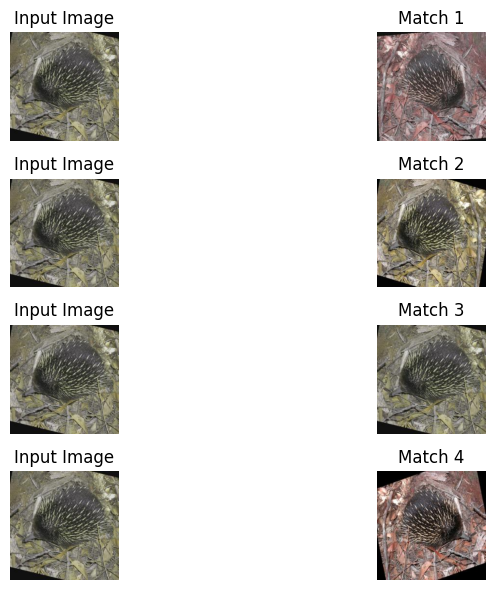

In [27]:
score= top_k_matches(image_path=enroll_img_paths[2], model=model, k=4)

### Query

In [36]:
# Example usage
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/45/Eopsaltria_australis_-_Mogo_Campground.jpg/640px-Eopsaltria_australis_-_Mogo_Campground.jpg"

pehle scores: [('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n02484975\\ILSVRC2012_val_00000013_aug_0.JPEG', array([[0.5958537]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n02484975\\ILSVRC2012_val_00000013_aug_1.JPEG', array([[0.5444288]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n02484975\\ILSVRC2012_val_00000013_aug_3.JPEG', array([[0.57408845]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n02484975\\ILSVRC2012_val_00000013_aug_4.JPEG', array([[0.54468524]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n01729977\\ILSVRC2012_val_00000029_aug_0.JPEG', array([[0.61482155]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n01729977\\ILSVRC2012_val_00000029_aug_1.JPEG', array([[0.59613836]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n01729977\\ILSVRC2012_val_00000029_aug_2.JPEG', array([[0.6416754]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mi

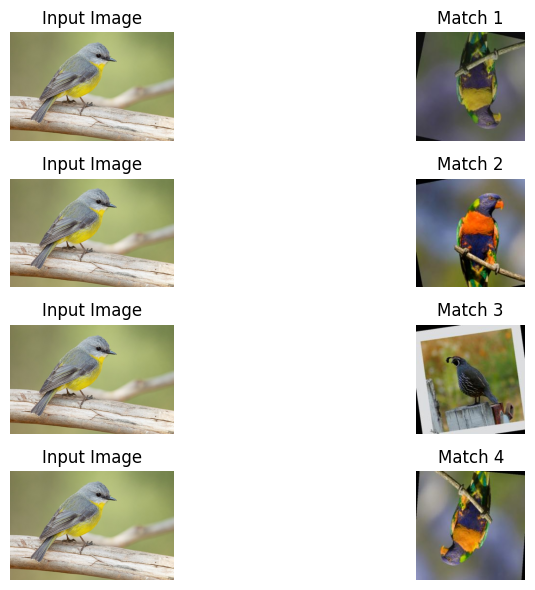

In [37]:
score= top_k_matches(url=image_url, model= model, k=4)